<figure>
  <IMG SRC="Logo.png"  WIDTH=150 ALIGN="right">
</figure>

## Projections of mean sea level and tides<br>
### Paper in Journal of Coastal and Hydraulic Structures
<b>Prepared by: H.G. Voortman</b>


<figure>
    <IMG SRC="https://www.python.org/static/community_logos/python-powered-w-200x80.png"  WIDTH=100 ALIGN="right">
</figure>

#### Description
- Demonstrating the effect of the sampling strategy

#### Packages

In [1]:
# General packages
import os
from scipy import signal
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import sqlite3 as sq
import datetime as dt
import sigfig as sf

import hvec_tide as tide

from constants import *

s:\JCHS_sea_level\.venv\Lib\site-packages\utide\harmonics.py:16: RuntimeWarning: invalid value encountered in cast
  nshallow = np.ma.masked_invalid(const.nshallow).astype(int)
s:\JCHS_sea_level\.venv\Lib\site-packages\utide\harmonics.py:17: RuntimeWarning: invalid value encountered in cast
  ishallow = np.ma.masked_invalid(const.ishallow).astype(int) - 1


In [2]:
tqdm.pandas()

#### Import high-frequency data for one year

In [3]:
cnxn = sq.connect('data_single_year_high_freq.db', detect_types = False)

In [4]:
sql = "SELECT Naam, Tijdstip, Waarde FROM data"
df = pd.read_sql(sql, cnxn)

In [5]:
df['Tijdstip'] = pd.to_datetime(df['Tijdstip'])
df['Waarde'] = df['Waarde'].div(100)

In [6]:
df.loc[df['Naam'] == 'IJmuiden Noordersluis', 'Naam'] = 'IJmuiden'

#### Sample highs and lows

In [7]:
def set_high_low_column(df):
    # Sample highs and lows
    dist =  50 # Horizontal distance between peaks
    # Add column with default values
    df['High and low water'] = False

    # Add high waters
    ids = signal.find_peaks(df['Waarde'], distance = dist)[0]
    df['High and low water'].iloc[ids] = True

    # Add low waters
    ids = signal.find_peaks(-df['Waarde'], distance = dist)[0]
    df['High and low water'].iloc[ids] = True
    return df

In [8]:
# Group per location
df = df.groupby('Naam', as_index = False).apply(lambda x: set_high_low_column(x))
df.reset_index(drop = True, inplace = True)

In [9]:
# Verification plot
def verification_plot(df):
    plt.figure(figsize = (20, 8))
    df.sort_values(by = 'Tijdstip', inplace = True)
    df = df.loc[df['Tijdstip'].between('2020-01-01', '2020-01-07')]
    t = df['Tijdstip']
    h = df['Waarde']
    plt.plot(t, h, label = 'All data')

    t = df.loc[df['High and low water'], 'Tijdstip']
    h = df.loc[df['High and low water'], 'Waarde']
    plt.plot(t, h, 'ro', label = 'High and low water')

    plt.title(df['Naam'].unique().item())    
    return

""


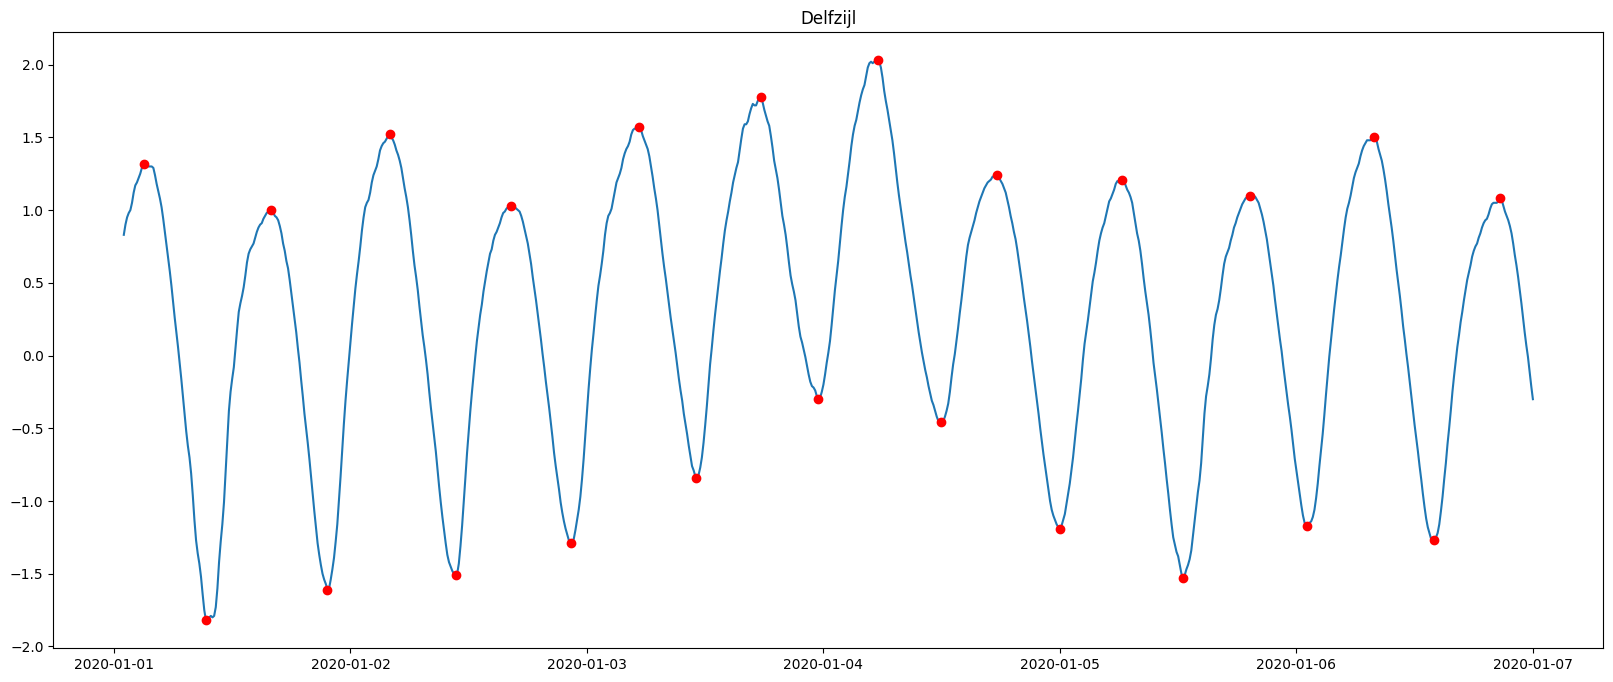

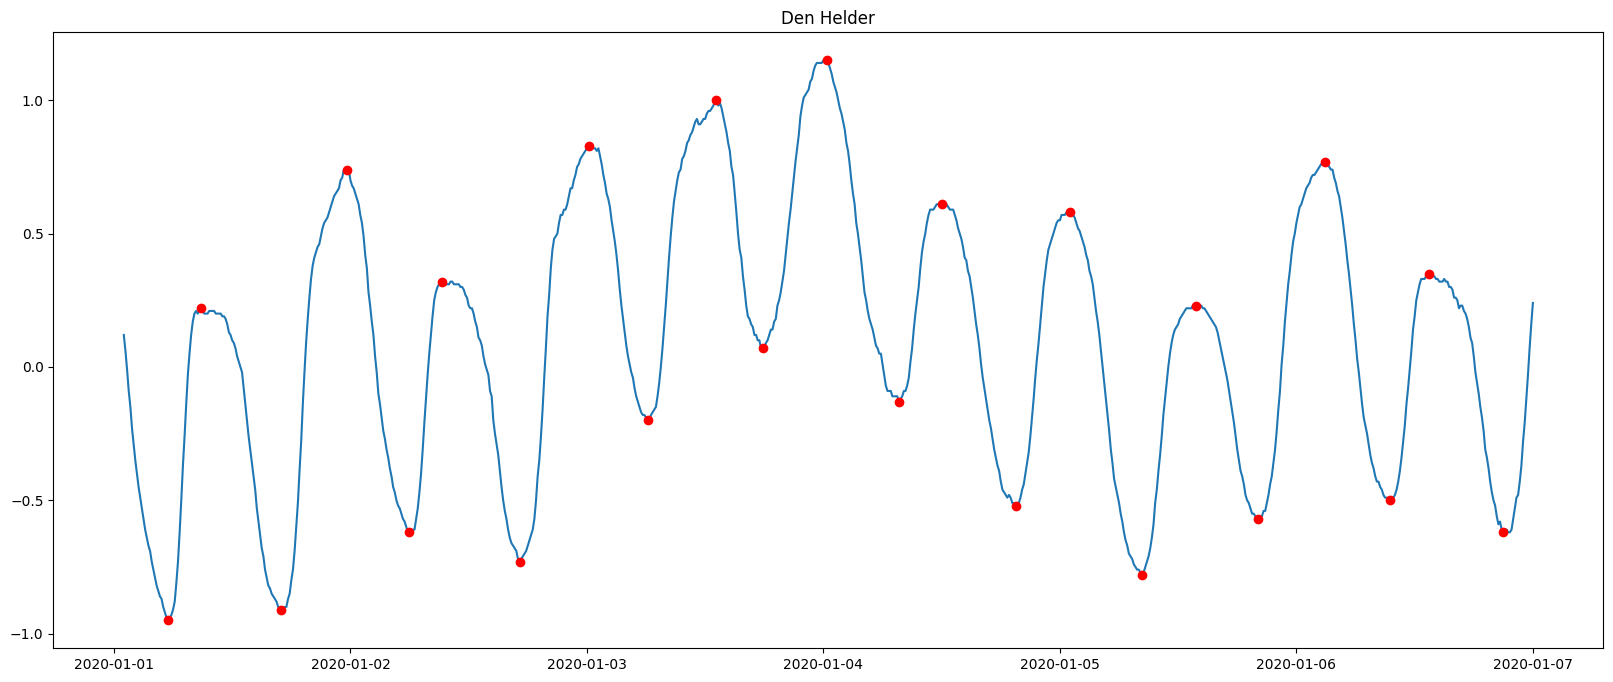

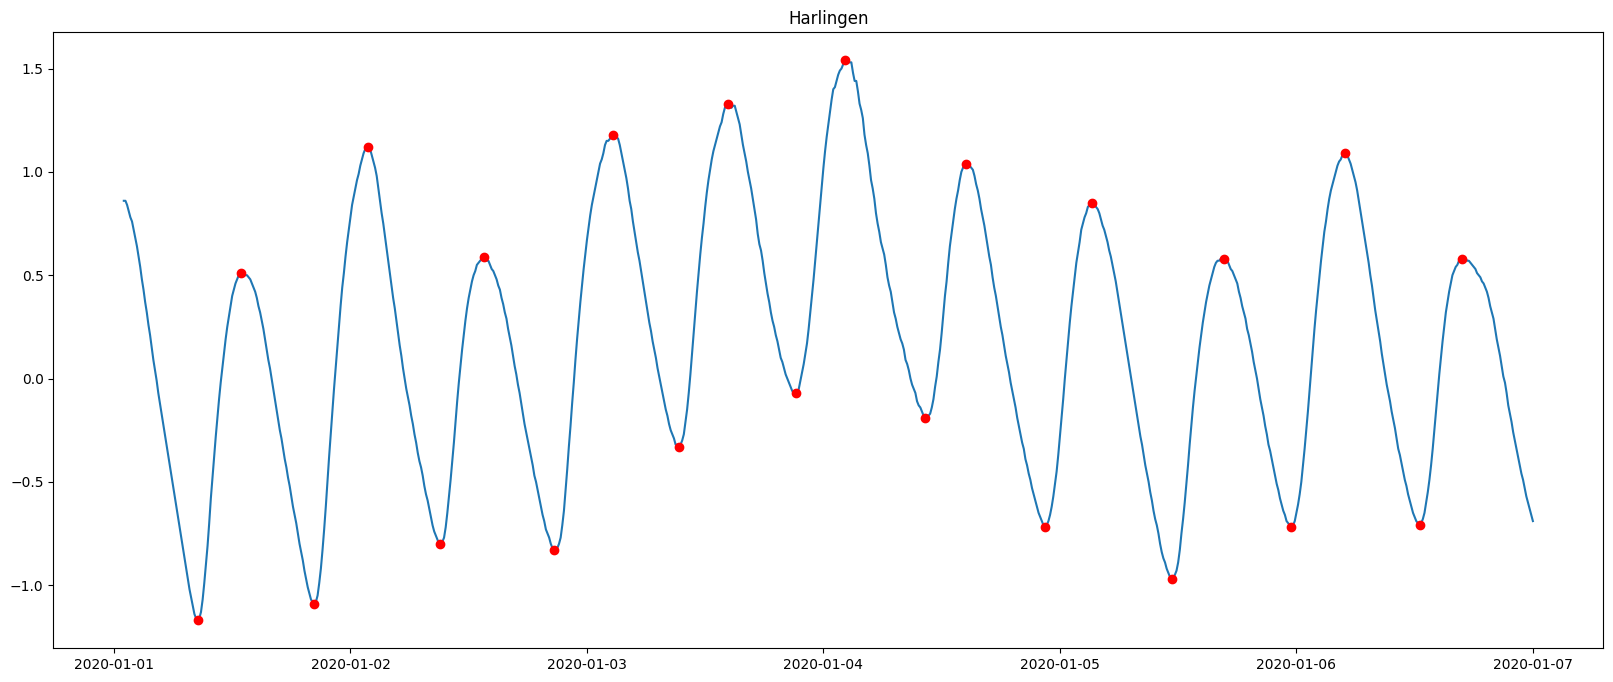

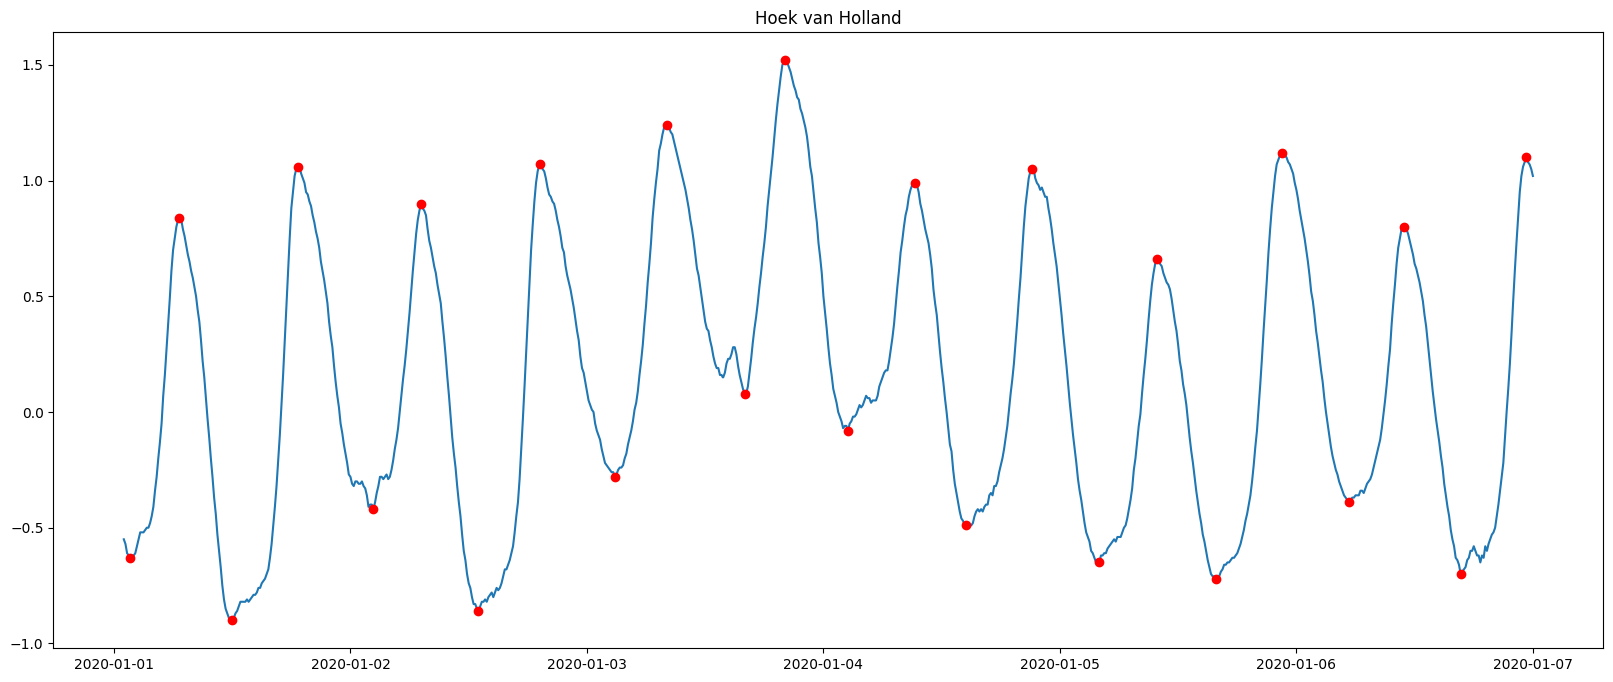

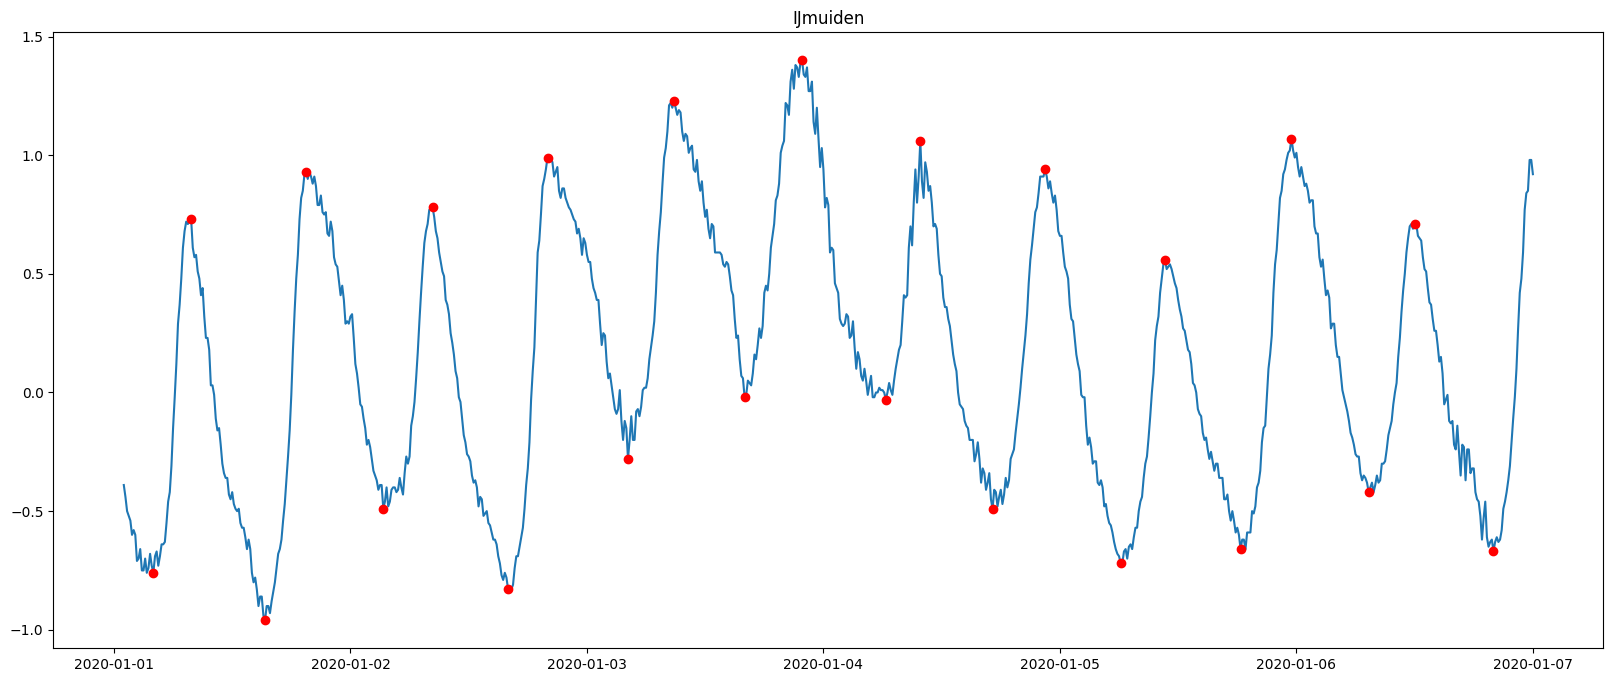

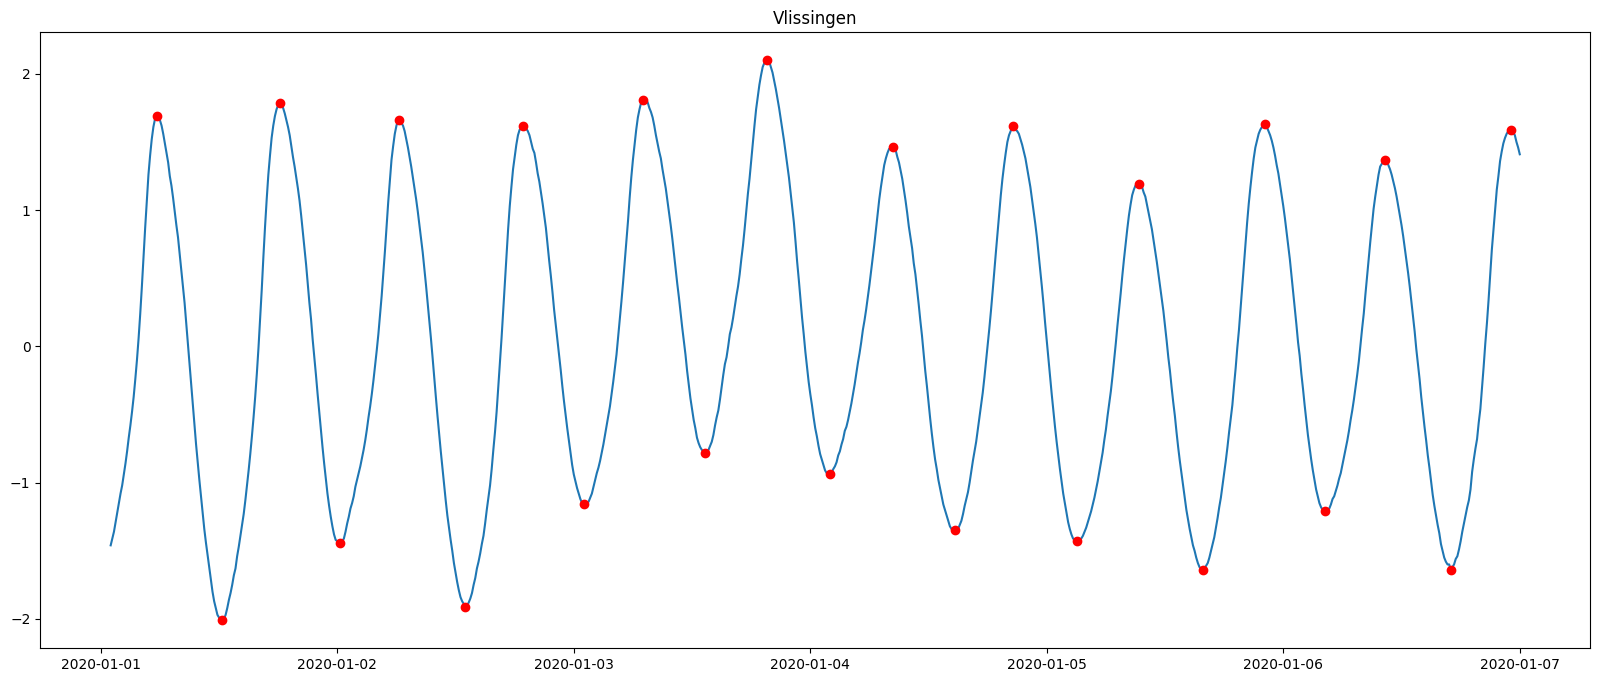

In [10]:
df.groupby('Naam').apply(lambda x: verification_plot(x))

#### Sample three hourly and hourly

In [11]:
df['Fixed times on 3 hour interval'] = (df['Tijdstip'].dt.hour%3 == 0) & (df['Tijdstip'].dt.minute == 0)
df['Fixed times on 1 hour interval'] = (df['Tijdstip'].dt.hour%1 == 0) & (df['Tijdstip'].dt.minute == 0)
df['Fixed times on 10 minute interval'] = df['Tijdstip'].dt.minute%10 == 0
df

,Naam,Tijdstip,Waarde,High and low water,Fixed times on 3 hour interval,Fixed times on 1 hour interval,Fixed times on 10 minute interval
0,Delfzijl,2020-01-01 01:00:00+01:00,0.83,False,False,True,True
1,Delfzijl,2020-01-01 01:10:00+01:00,0.90,False,False,False,True
2,Delfzijl,2020-01-01 01:20:00+01:00,0.95,False,False,False,True
3,Delfzijl,2020-01-01 01:30:00+01:00,0.98,False,False,False,True
4,Delfzijl,2020-01-01 01:40:00+01:00,1.00,False,False,False,True
...,...,...,...,...,...,...,...
321263,Vlissingen,2020-12-31 00:20:00+01:00,0.01,False,False,False,True
321264,Vlissingen,2020-12-31 00:30:00+01:00,0.18,False,False,False,True
321265,Vlissingen,2020-12-31 00:40:00+01:00,0.37,False,False,False,True
321266,Vlissingen,2020-12-31 00:50:00+01:00,0.58,False,False,False,True


#### Arithmetic and tidal means

In [12]:
methods = [
      'High and low water'
    , 'Fixed times on 3 hour interval'
    , 'Fixed times on 1 hour interval'
    , 'Fixed times on 10 minute interval']

In [13]:
def get_msl(df):
  """
  Expect data grouped per station
  """
  res = pd.DataFrame()
  for meth in methods:
    tmp = pd.DataFrame()
    data = df.loc[df[meth]]
    sol = tide.run_utide_solve(
        data['Tijdstip'], data['Waarde'], lat = 52
      , method = 'robust'
      , constit = ['M2', 'S2', 'M4', 'SA', 'N2', 'O1', 'MS4']
      , conf_int = 'none'
      , trend = False)
    tmp = tide.parsers.parse_utide(sol)[['z0', 'zmean']]
    tmp['Sampling method'] = meth
    res = pd.concat([res, tmp])

    num_cols = ['z0', 'zmean']
    
    for cl in num_cols:
      res[cl] = res[cl].apply(lambda x: sf.round(x, decimals = 2))
  
  return res
    

In [14]:
res = df.groupby('Naam').progress_apply(lambda x: get_msl(x))

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:29<00:00,  4.93s/it]


In [15]:
res.reset_index(inplace = True)
res.drop(columns = 'level_1', inplace = True)
res.rename(columns = {
      'z0': 'Tidal mean sea level'
    , 'zmean': 'Arithmetic mean sea level'}, inplace = True)
res

,Naam,Tidal mean sea level,Arithmetic mean sea level,Sampling method
0,Delfzijl,-0.07,-0.06,High and low water
1,Delfzijl,0.18,0.21,Fixed times on 3 hour interval
2,Delfzijl,0.18,0.20,Fixed times on 1 hour interval
3,Delfzijl,0.18,0.20,Fixed times on 10 minute interval
4,Den Helder,0.07,-0.04,High and low water
5,Den Helder,0.04,0.07,Fixed times on 3 hour interval
6,Den Helder,0.04,0.07,Fixed times on 1 hour interval
7,Den Helder,0.04,0.07,Fixed times on 10 minute interval
8,Harlingen,0.02,0.06,High and low water
9,Harlingen,0.11,0.15,Fixed times on 3 hour interval


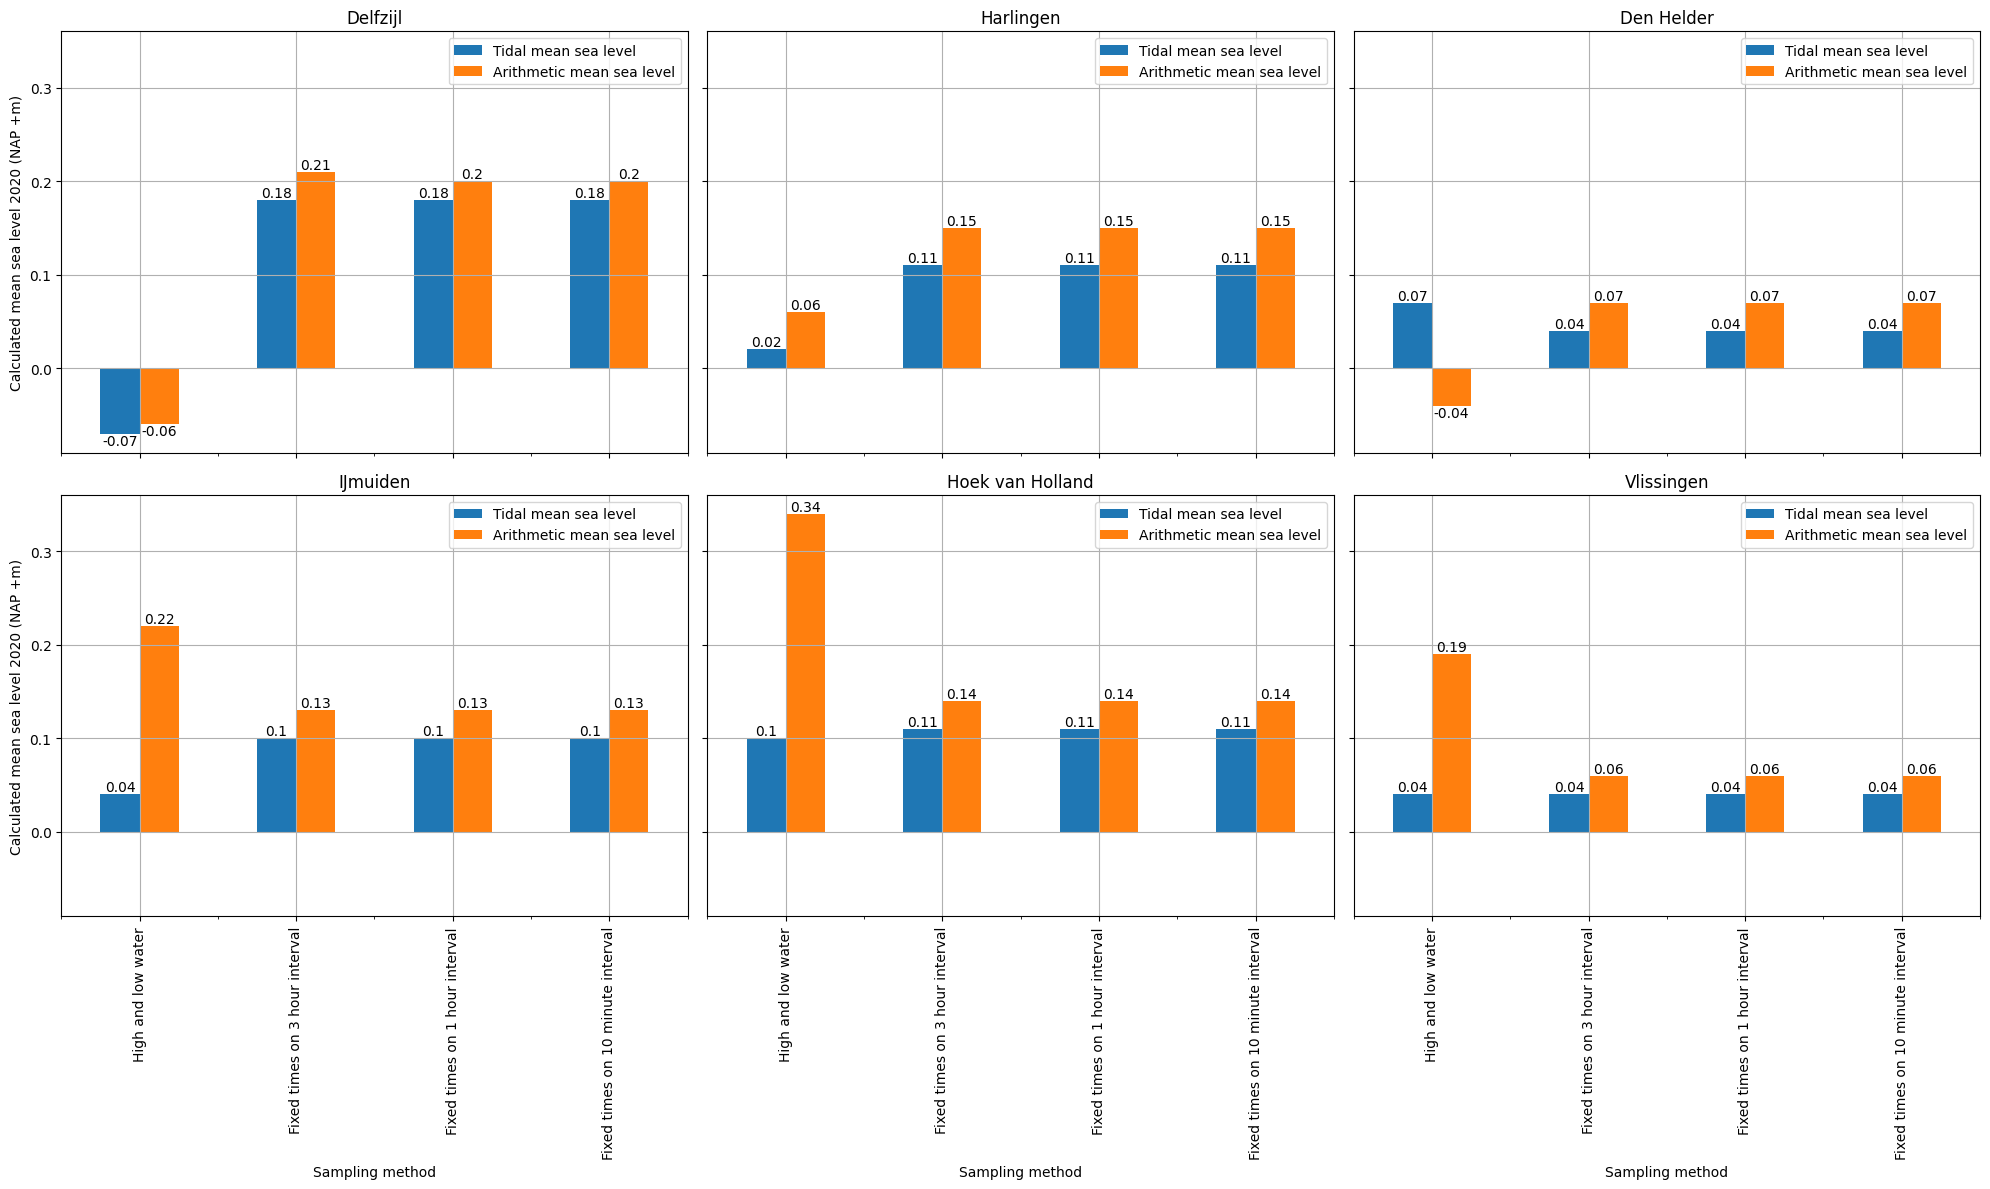

In [19]:
nrows = 2
ncols = 3
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, sharey = True, figsize = (20, 12))
for i, nm in enumerate(names):
    row = i//ncols
    col = i%ncols
    ax = axs[row, col]
    data = res.loc[res['Naam'] == nm]
    data.plot.bar(x = 'Sampling method', ax = ax)
    ax.grid()
    ax.set_title(nm)
    ax.set_ylabel('Calculated mean sea level 2020 (NAP +m)')
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])

fig.tight_layout()
fig.savefig(f'{PICTURES}/effect_of_sampling.jpg')

#### End script
Prepared by HVEC lab, 2022